In [1]:
import torch
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim) -> None:
        super().__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 0),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 2, 0),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(64*6*6, self.latent_dim),
        )
        self.mu_linear = nn.Linear(self.latent_dim, self.latent_dim)
        self.sigma_linear = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        return self.mu_linear(x), torch.exp(self.sigma_linear(x))    
    
class Decoder(nn.Module):
    def __init__(self, latent_dim) -> None:
        super().__init__()
        #sample from standard normal distribution
        self.latent_dim = latent_dim
        self.standard_normal = torch.distributions.Normal(0,1)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 64*6*6),
            nn.LeakyReLU(),
            nn.Unflatten(1, (64, 6, 6)),
            nn.ConvTranspose2d(64, 32, 3, 2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2),
            nn.Tanh()
        )
    def reparameterize(self, mu, sigma):
        epsilon = self.standard_normal.sample(mu.shape)
        epsilon = epsilon.to('cuda')
        latent = mu + epsilon * sigma
        return latent
    
    def sample(self, num_samples):
        latent = self.standard_normal.sample((num_samples, self.latent_dim))
        latent = latent.to('cuda')
        return self.decoder(latent)
    
    def forward(self, mu, sigma):
        latent = self.reparameterize(mu, sigma)
        return self.decoder(latent)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = MNIST(root='.', train=True, download=True, transform=transform)
test_data = MNIST(root='.', train=False, download=True, transform=transform)
valid_test, test_data = torch.utils.data.random_split(test_data, [5000, 5000])

In [4]:
batch_size = 1024
optimizer = optim.Adam
criterion = nn.MSELoss()
latent_dim = 15
learning_rate = 1e-3

In [5]:
# setting seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [6]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_test, batch_size=batch_size, shuffle=False)

In [7]:
def display_image(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(5, 3))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray')
    plt.show()

In [8]:
def loss_fn(x, x_hat, mu, sigma, kl_weight = 3):
    reconstruction_loss = ((x - x_hat)**2).sum()
    kl_divergence = 0.5 * torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) - 1)
    # print(f"Reconstruction Loss: {reconstruction_loss}, KL Divergence: {kl_divergence}")
    return reconstruction_loss,  1.2 * kl_divergence

In [9]:
def trainer(encoder, decoder, train_loader, valid_loader, optimizer, criterion, lr, epochs=1):
    encoder = encoder.to('cuda')
    decoder = decoder.to('cuda')
    optimizer = optimizer(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        for i, (x, _) in enumerate(train_loader):
            x = x.to('cuda')
            optimizer.zero_grad()
            mu, sigma = encoder(x)
            x_hat = decoder(mu, sigma)
            recon_loss, kl_div = loss_fn(x, x_hat, mu, sigma)
            loss = recon_loss + kl_div
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Epoch: {epoch}, Iteration: {i}, Loss: {recon_loss.item()}, KL: {kl_div.item()}')
        encoder.eval()
        decoder.eval()
        if epoch % 5 == 0:
            with torch.no_grad():
                total_loss = 0
                for i, (x, _) in enumerate(valid_loader):
                    x = x.to('cuda')
                    mu, sigma = encoder(x)
                    x_hat = decoder(mu, sigma)
                    recon_loss, kl_div = loss_fn(x, x_hat, mu, sigma)
                    loss = recon_loss + kl_div
                    display_image(x[0].squeeze().cpu().numpy(), x_hat[0].squeeze().cpu().numpy())
                    total_loss += loss.item()
                print(f'Epoch: {epoch}, Iteration: {i}, Loss: {recon_loss.item()}, KL: {kl_div.item()}')

                # sample from the decoder
                samples = decoder.sample(1)
                display_image(samples[0].squeeze().cpu().numpy(), samples[0].squeeze().cpu().numpy())
                

In [10]:
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)

Epoch: 0, Iteration: 0, Loss: 101892.6796875, KL: 470.64508056640625


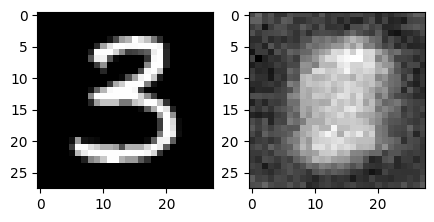

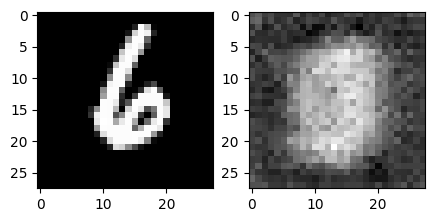

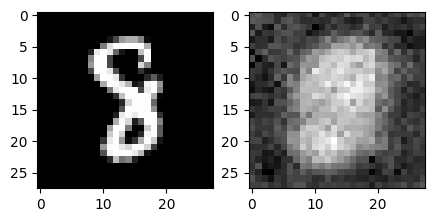

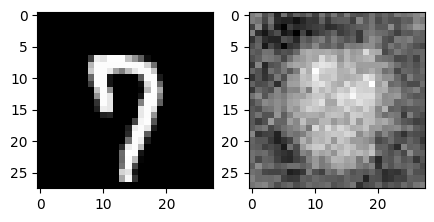

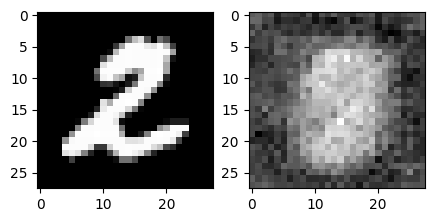

Epoch: 0, Iteration: 4, Loss: 50059.89453125, KL: 1798.4620361328125


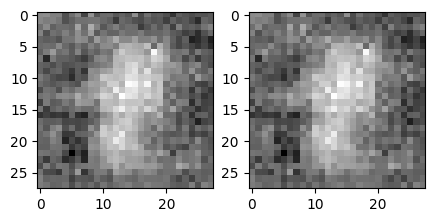

Epoch: 1, Iteration: 0, Loss: 55882.58203125, KL: 1971.8101806640625
Epoch: 2, Iteration: 0, Loss: 42470.09375, KL: 5445.02734375
Epoch: 3, Iteration: 0, Loss: 37115.73828125, KL: 7533.326171875
Epoch: 4, Iteration: 0, Loss: 33548.296875, KL: 8042.9609375
Epoch: 5, Iteration: 0, Loss: 31175.2265625, KL: 8835.1513671875


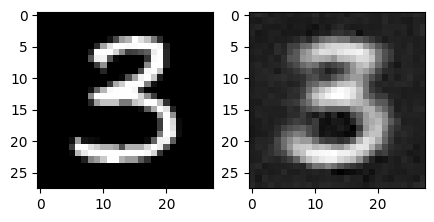

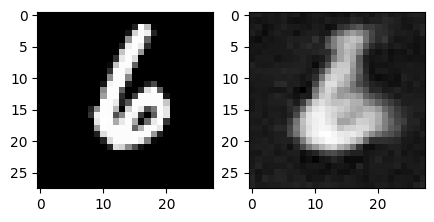

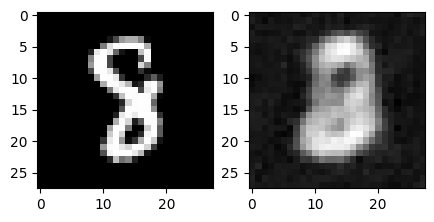

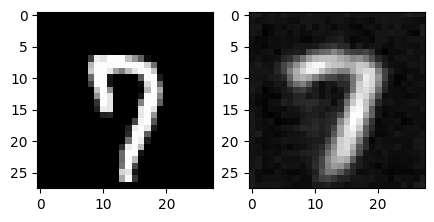

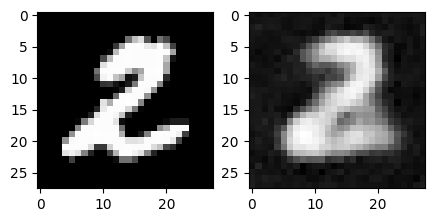

Epoch: 5, Iteration: 4, Loss: 26314.044921875, KL: 8347.162109375


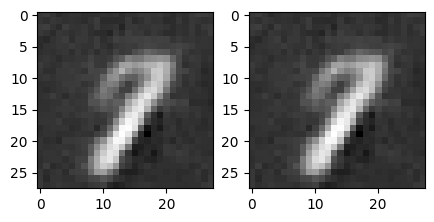

Epoch: 6, Iteration: 0, Loss: 29687.65625, KL: 9466.9345703125
Epoch: 7, Iteration: 0, Loss: 28604.90625, KL: 9319.78125
Epoch: 8, Iteration: 0, Loss: 27189.484375, KL: 10344.654296875
Epoch: 9, Iteration: 0, Loss: 26597.427734375, KL: 10122.923828125
Epoch: 10, Iteration: 0, Loss: 26267.884765625, KL: 10090.7626953125


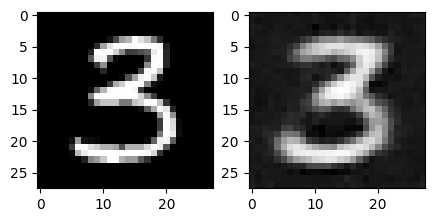

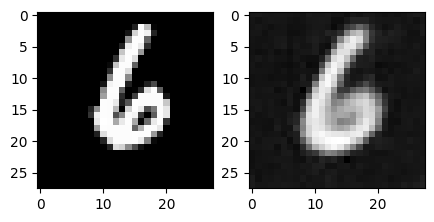

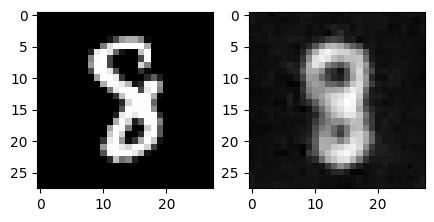

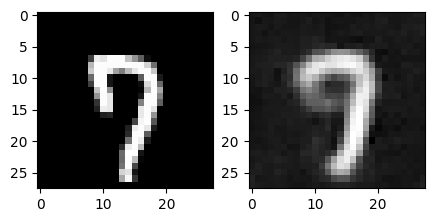

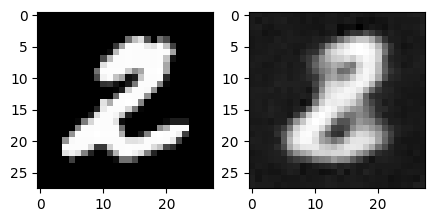

Epoch: 10, Iteration: 4, Loss: 22706.05078125, KL: 9207.5830078125


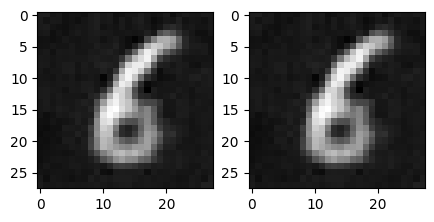

Epoch: 11, Iteration: 0, Loss: 25324.755859375, KL: 10350.642578125
Epoch: 12, Iteration: 0, Loss: 24080.296875, KL: 10737.427734375
Epoch: 13, Iteration: 0, Loss: 24309.3828125, KL: 10602.744140625
Epoch: 14, Iteration: 0, Loss: 23711.70703125, KL: 10570.498046875
Epoch: 15, Iteration: 0, Loss: 23542.51171875, KL: 11052.208984375


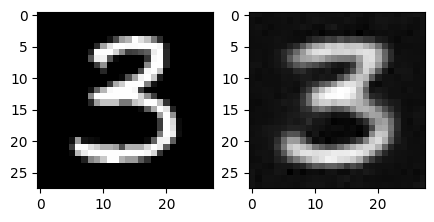

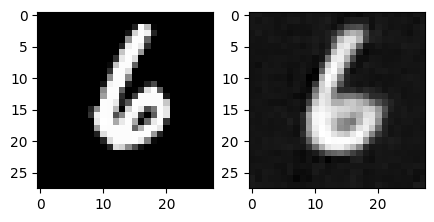

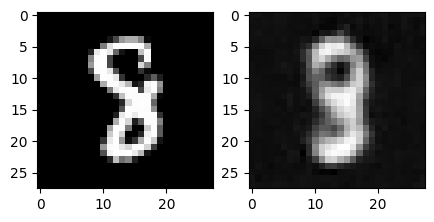

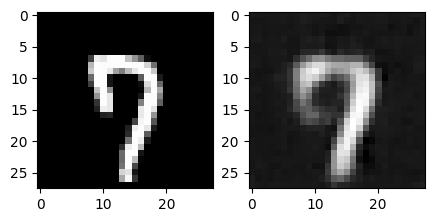

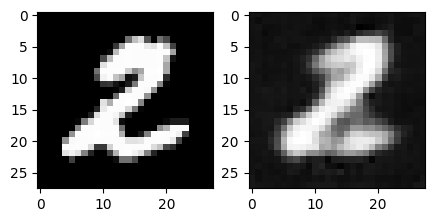

Epoch: 15, Iteration: 4, Loss: 20801.6171875, KL: 9852.71484375


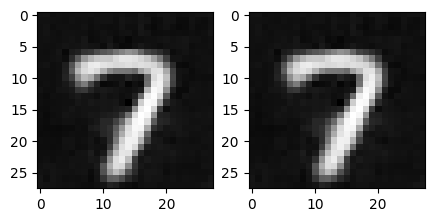

Epoch: 16, Iteration: 0, Loss: 23124.39453125, KL: 11114.609375
Epoch: 17, Iteration: 0, Loss: 23392.87109375, KL: 11422.263671875
Epoch: 18, Iteration: 0, Loss: 22979.89453125, KL: 11256.865234375
Epoch: 19, Iteration: 0, Loss: 22349.73046875, KL: 11510.1201171875
Epoch: 20, Iteration: 0, Loss: 22184.29296875, KL: 11837.26953125


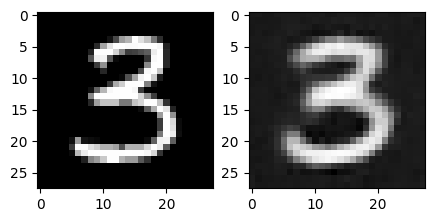

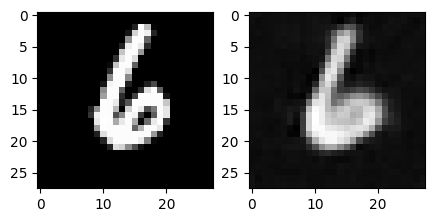

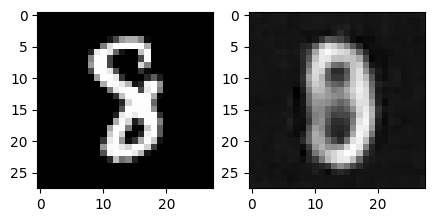

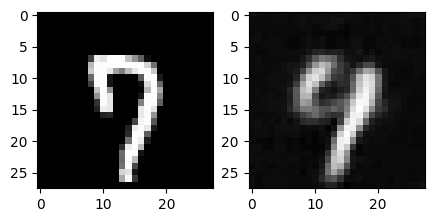

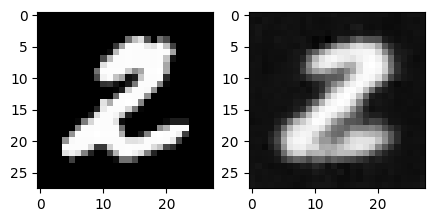

Epoch: 20, Iteration: 4, Loss: 19909.072265625, KL: 10164.7080078125


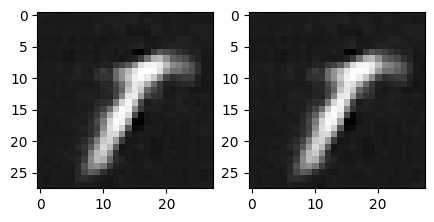

Epoch: 21, Iteration: 0, Loss: 22029.015625, KL: 11430.2255859375
Epoch: 22, Iteration: 0, Loss: 22234.123046875, KL: 11361.7197265625
Epoch: 23, Iteration: 0, Loss: 21720.88671875, KL: 11445.046875
Epoch: 24, Iteration: 0, Loss: 21237.8359375, KL: 11507.6767578125
Epoch: 25, Iteration: 0, Loss: 21550.3984375, KL: 11444.26953125


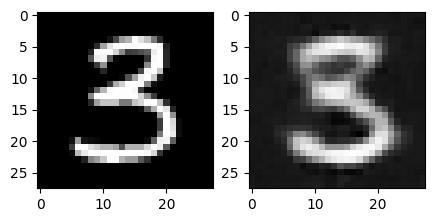

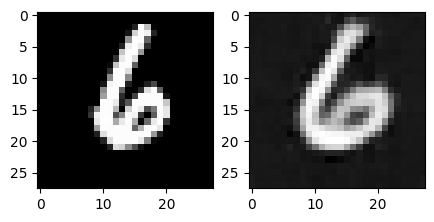

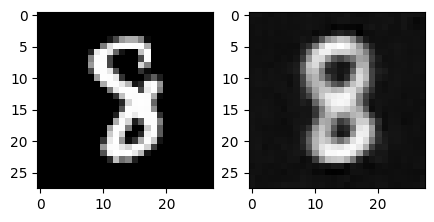

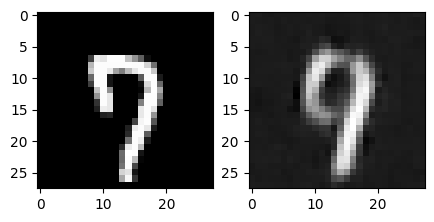

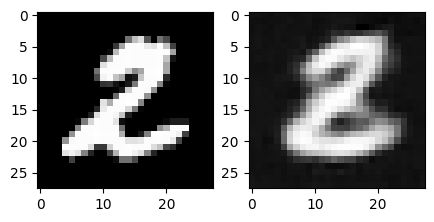

Epoch: 25, Iteration: 4, Loss: 18881.71875, KL: 10633.74609375


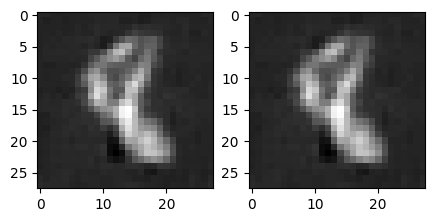

Epoch: 26, Iteration: 0, Loss: 21259.216796875, KL: 12034.7724609375
Epoch: 27, Iteration: 0, Loss: 21128.34765625, KL: 11793.66796875
Epoch: 28, Iteration: 0, Loss: 21002.859375, KL: 11919.8994140625
Epoch: 29, Iteration: 0, Loss: 20779.36328125, KL: 11962.0947265625
Epoch: 30, Iteration: 0, Loss: 20713.21875, KL: 11826.4306640625


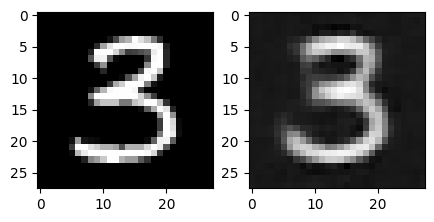

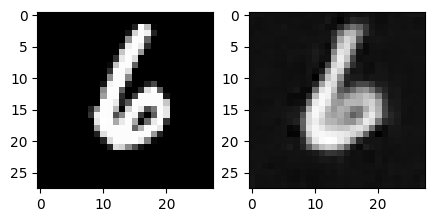

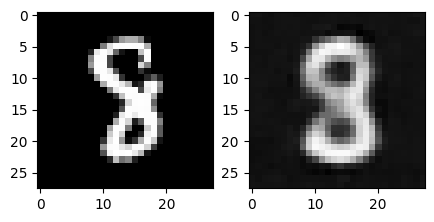

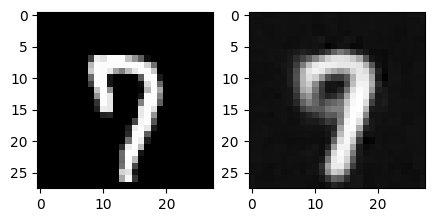

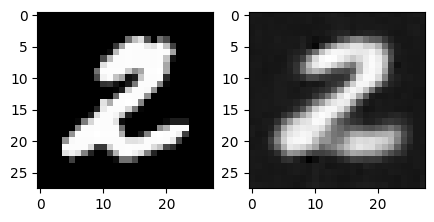

Epoch: 30, Iteration: 4, Loss: 18209.841796875, KL: 10886.953125


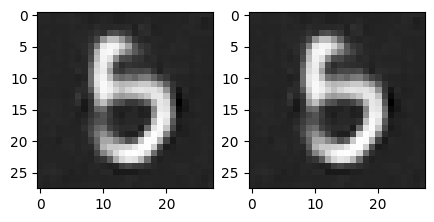

Epoch: 31, Iteration: 0, Loss: 20569.1640625, KL: 12193.240234375
Epoch: 32, Iteration: 0, Loss: 20715.28125, KL: 12164.92578125
Epoch: 33, Iteration: 0, Loss: 20394.80859375, KL: 12296.7431640625
Epoch: 34, Iteration: 0, Loss: 20557.939453125, KL: 11895.669921875
Epoch: 35, Iteration: 0, Loss: 20483.318359375, KL: 12036.3544921875


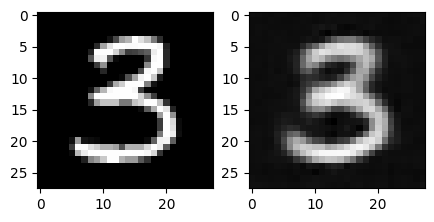

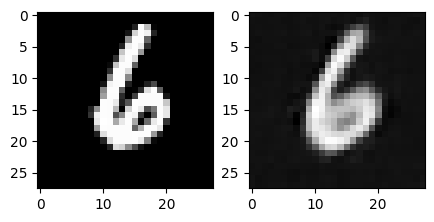

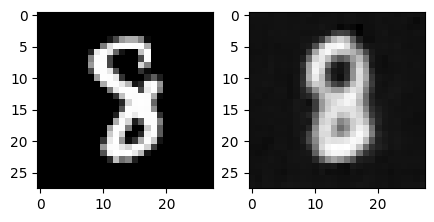

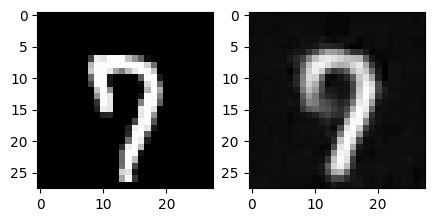

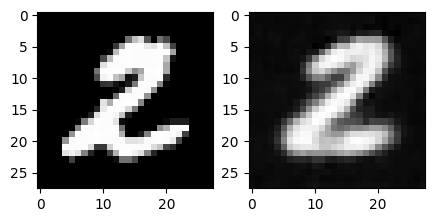

Epoch: 35, Iteration: 4, Loss: 18103.40234375, KL: 10859.1328125


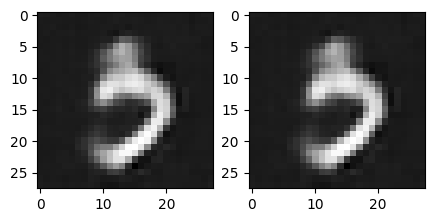

Epoch: 36, Iteration: 0, Loss: 19865.97265625, KL: 12318.6494140625
Epoch: 37, Iteration: 0, Loss: 19856.546875, KL: 12170.33203125
Epoch: 38, Iteration: 0, Loss: 19966.90625, KL: 12461.9462890625
Epoch: 39, Iteration: 0, Loss: 19848.34765625, KL: 12400.7392578125


KeyboardInterrupt: 

In [11]:
trainer(encoder, decoder, train_loader, valid_loader, optimizer, criterion, learning_rate, epochs=100)

In [12]:
# save model
torch.save(encoder.state_dict(), 'vae_encoder.pth')
torch.save(decoder.state_dict(), 'vae_decoder.pth')

In [13]:
decoder = Decoder(latent_dim)
decoder.load_state_dict(torch.load('vae_decoder.pth'))
decoder.eval()
decoder = decoder.to('cuda')

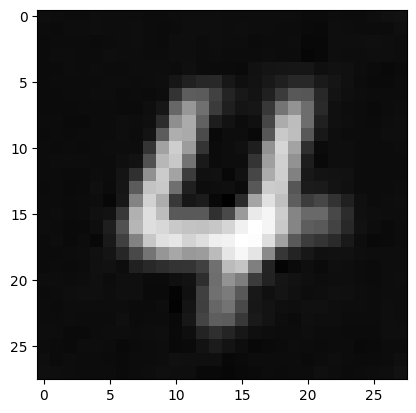

In [20]:
images = decoder.sample(1)
images = images.squeeze().cpu().detach().numpy()
plt.imshow(images, cmap='gray')
plt.show()